In [1]:
!pip install keras-cv keras-core -q --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 76.5 MB/s eta 0:00:00


In [2]:
import os
import logging
import warnings as wr
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras_cv as kcv
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

Using TensorFlow backend


In [3]:
# Random Configuration - All
RND = True
if not RND:
  SEED = 76998669
  os.environ['PYTHONHASHSEED'] = str(SEED)
  tf.compat.v1.set_random_seed(SEED)
  tf.random.set_seed(SEED)
  np.random.seed(SEED)
  rnd.seed(SEED)

# OS Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Warning Congiguration
wr.simplefilter(action='ignore', category=FutureWarning)
wr.simplefilter(action='ignore', category=Warning)

# TensorFlow Configuration
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
# Plotting Functions
def plot_losses(history, figsize, name_jpg):
  best_epoch = np.argmax(history['val_accuracy'])
  fig, axes = plt.subplots(2,1, figsize=figsize, dpi=200)

  axes[0].plot(history['loss'], label='Training Loss', color='#9859C5', alpha=.8)
  axes[0].plot(history['val_loss'], label='Validation Loss', color='#4D61E2', alpha=.8)
  axes[0].set_title('Loss')
  axes[0].legend()
  axes[0].grid(alpha=.3)

  axes[1].plot(history['accuracy'], label='Training Accuracy', color='#9859C5', alpha=.8)
  axes[1].plot(history['val_accuracy'], label='Validation Accuracy', color='#4D61E2', alpha=.8)
  axes[1].plot(best_epoch, history['val_accuracy'][best_epoch], marker='d', alpha=0.8, markersize=10, color='#4D61E2')
  axes[1].set_title('Accuracy')
  axes[1].legend()
  axes[1].grid(alpha=.3)

  plt.savefig(name_jpg)
  plt.show()

def plot_images(images, labels, index=0, rows=1, cols=1, normalized=False):
  data_rescaling = tkl.Rescaling(scale=1./255)
  if normalized==False:
    IMGS_= data_rescaling(images)
  size = rows*cols
  diff = len(images)-(size+index)
  if diff <= 0:
    size = len(images)-index
    plt.figure(figsize=(cols,rows), dpi=200)
    for i in range(size):
      ax = plt.subplot(rows, cols, i + 1)
      plt.imshow(IMGS_[index + i])
      plt.title(labels[i], fontdict={"fontsize":5}, pad=2)
      plt.axis("off")

In [5]:
!wget https://storage.googleapis.com/storage.barbiero.dev/public_data_clean_balanced_splitted.npz

--2023-11-10 23:55:26--  https://storage.googleapis.com/storage.barbiero.dev/public_data_clean_balanced_splitted.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c03::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229962973 (219M) [application/octet-stream]
Saving to: ‘public_data_clean_balanced_splitted.npz’

public_data_clean_b 100%[===================>] 219.31M  23.9MB/s    in 9.6s    

2023-11-10 23:55:36 (22.9 MB/s) - ‘public_data_clean_balanced_splitted.npz’ saved [229962973/229962973]



In [7]:
X_train_val, y_train_val, X_test, y_test = np.load('public_data_clean_balanced_splitted.npz', allow_pickle=True).values()

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = 0.15,
    **({"random_state":SEED} if not RND else {}),
    stratify = y_train_val
)

y_train = tfk.utils.to_categorical(y_train,len(np.unique(y_train)))
y_val = tfk.utils.to_categorical(y_val,len(np.unique(y_val)))
y_test = tfk.utils.to_categorical(y_test,len(np.unique(y_test)))

In [8]:
batch_size = 32
image_size = 96
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()

# Get the Shape of IN OUT
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

train_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_ds = train_ds.ragged_batch(batch_size)
val_ds = val_ds.ragged_batch(batch_size)

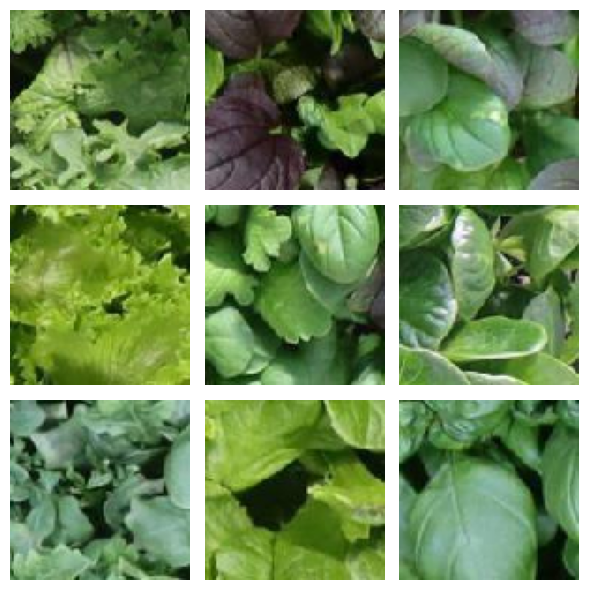

In [9]:
batch = next(iter(train_ds.take(1)))
image_batch = batch[0]
label_batch = batch[1]

kcv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

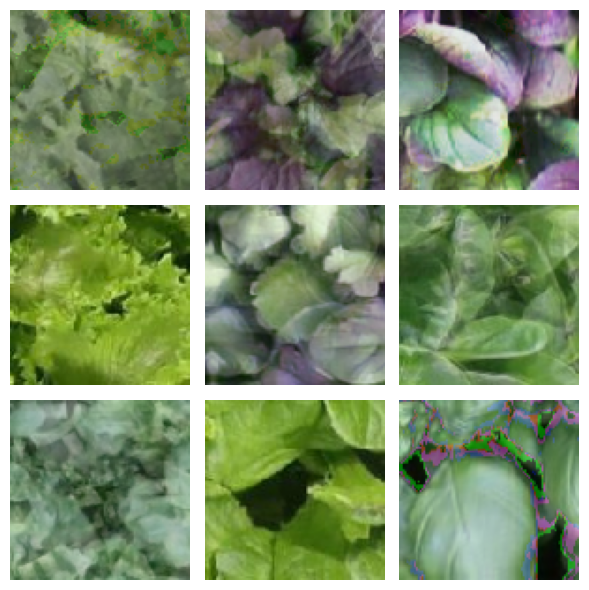

In [10]:
augmix = kcv.layers.AugMix([0, 255])
augmenters = [augmix]

image_batch = augmix(image_batch)
kcv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

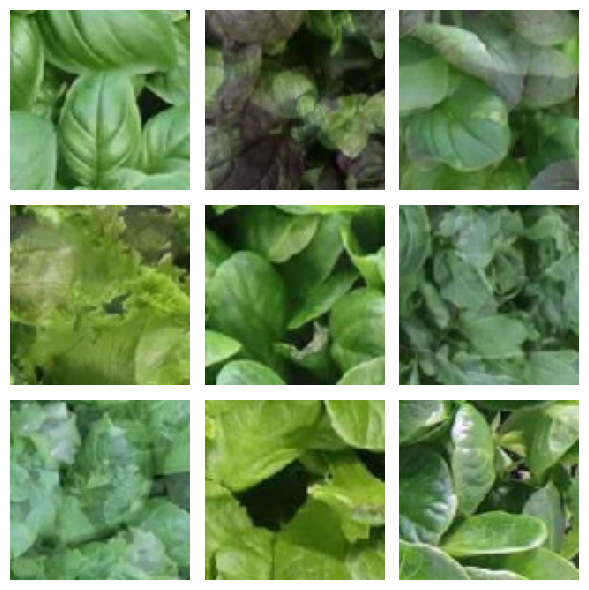

In [ ]:
mix_up = kcv.layers.MixUp()
# MixUp needs to modify both images and labels
inputs = {"images": image_batch, "labels": label_batch}

kcv.visualization.plot_image_gallery(
    mix_up(inputs)["images"],
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

#cut_mix_or_mix_up = kcv.layers.RandomChoice([cut_mix, mix_up], batchwise=True)
#augmenters += [cut_mix_or_mix_up]

In [12]:
from keras.applications.convnext import preprocess_input

def apple_elixir_model(input_shape, output_shape):

  # TO CHANGE - res of the Model
  backbone = tfk.applications.ConvNeXtBase(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    classes=2,
    classifier_activation='softmax'
  )

  backbone.trainable = False

  input_layer = tfkl.Input(input_shape, name="AE_input_layer")

  x = preprocess_input(input_layer)
  x = backbone(x)
  x = tfkl.GlobalAveragePooling2D(name="AE_global_average_pooling2d")(x)
  x = tfkl.Dense(units=128,activation=tfkl.LeakyReLU(alpha=0.1), name="AE_dense")(x)
  x = tfkl.Dropout(0.6, name="AE_dropout")(x)
  output_layer = tfkl.Dense(units=output_shape,activation='softmax', name="AE_output_layer")(x)


  model = tfk.Model(input_layer, output_layer)

  # Compile the model
  model.compile(
      loss=tfk.losses.CategoricalCrossentropy(),
      optimizer=tfk.optimizers.Nadam(learning_rate=0.0001, weight_decay=0.001),
      metrics=['accuracy']
  )

  return model

model = apple_elixir_model(input_shape,output_shape)

In [13]:
EPOCHS = 200

# Train the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',                         # Metric to monitor (validation mean squared error in this case)
    patience=5,                                     # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.85,                                    # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                                     # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                                     # Minimum learning rate
)

callbacks = [early_stopping,lr_scheduler]

history = model.fit(
    train_ds,
    epochs = EPOCHS,
    validation_data = val_ds,
    callbacks = callbacks
).history

Epoch 1/200
29/29 [==============================] - 56s 976ms/step - loss: 1.1436 - accuracy: 0.5381 - val_loss: 0.6938 - val_accuracy: 0.5941 - lr: 1.0000e-04
Epoch 2/200
29/29 [==============================] - 9s 326ms/step - loss: 0.9098 - accuracy: 0.5719 - val_loss: 0.6066 - val_accuracy: 0.6876 - lr: 1.0000e-04
Epoch 3/200
29/29 [==============================] - 7s 259ms/step - loss: 0.7623 - accuracy: 0.6220 - val_loss: 0.5539 - val_accuracy: 0.7260 - lr: 1.0000e-04
Epoch 4/200
29/29 [==============================] - 7s 254ms/step - loss: 0.6630 - accuracy: 0.6460 - val_loss: 0.5240 - val_accuracy: 0.7426 - lr: 1.0000e-04
Epoch 5/200
29/29 [==============================] - 9s 325ms/step - loss: 0.6171 - accuracy: 0.6895 - val_loss: 0.5030 - val_accuracy: 0.7734 - lr: 1.0000e-04
Epoch 6/200
29/29 [==============================] - 7s 250ms/step - loss: 0.5542 - accuracy: 0.7026 - val_loss: 0.4867 - val_accuracy: 0.7836 - lr: 1.0000e-04
Epoch 7/200
29/29 [====================

In [14]:
NAME_MODEL = "ConvNeXtCV_001"
NAME_PLOT = NAME_MODEL + "_plot"

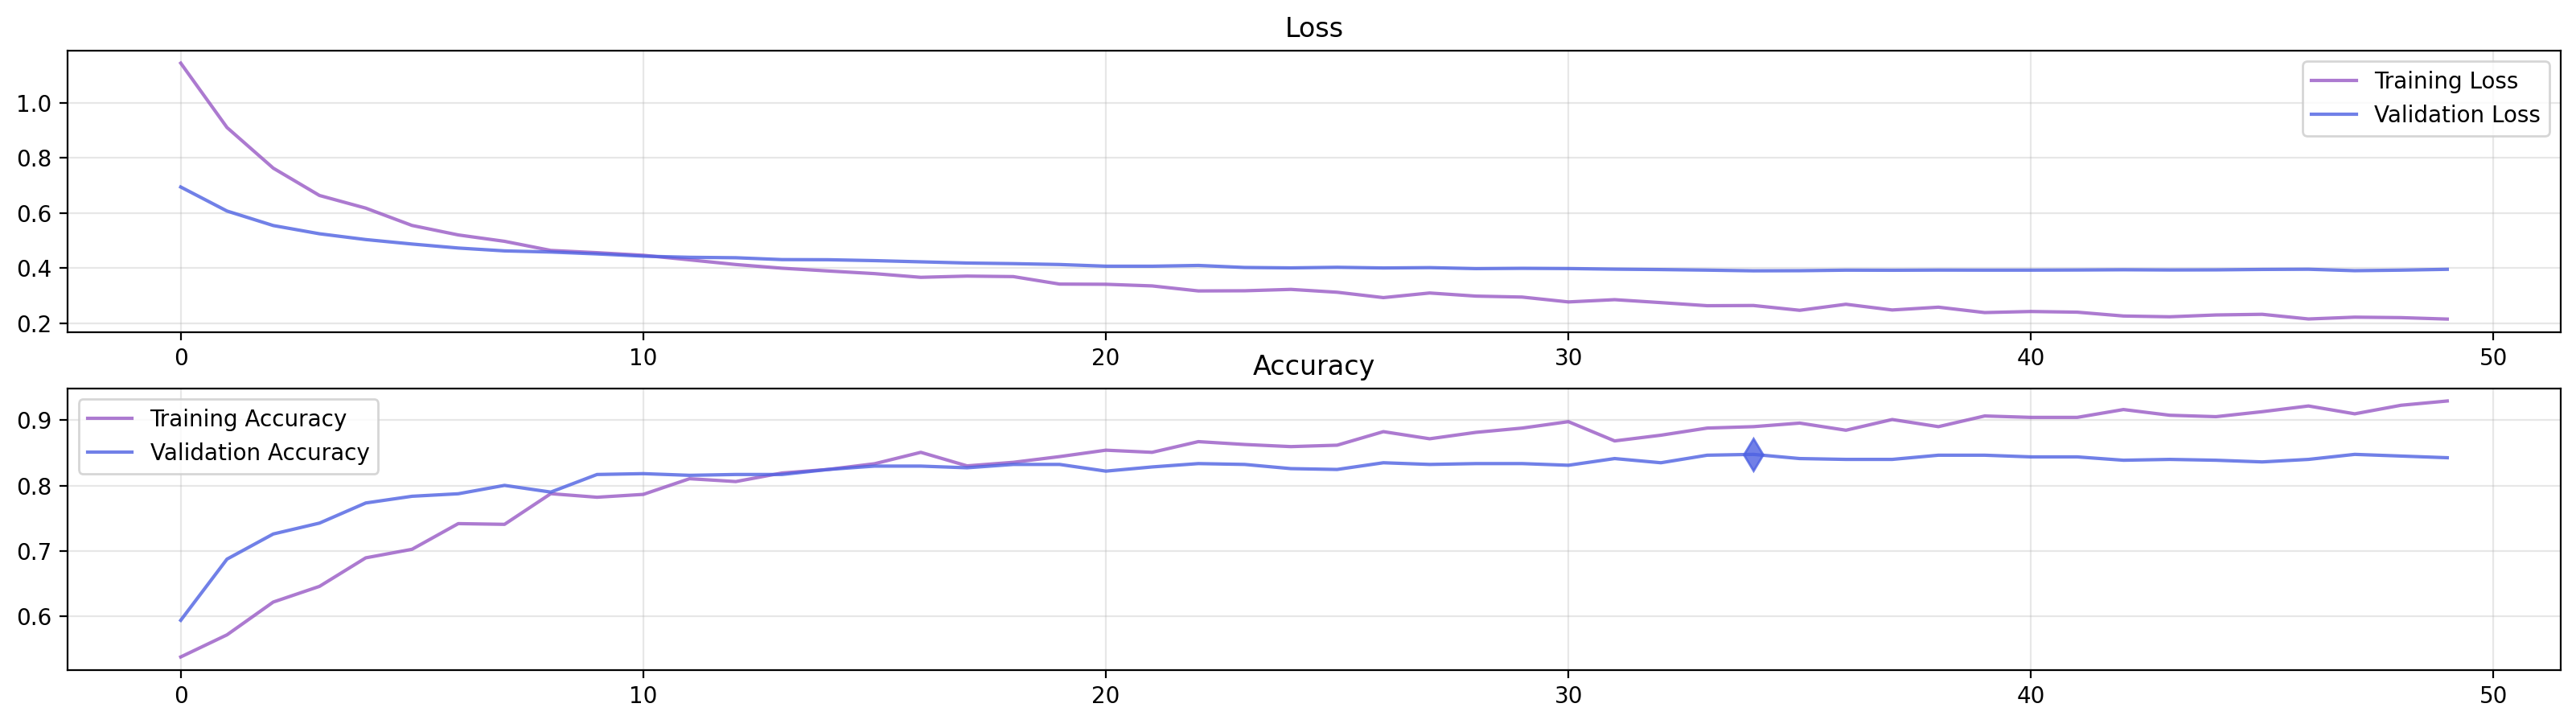

Accuracy Score over the Test Set: 0.9325



In [15]:
plot_losses(history, (20,5), NAME_PLOT)

test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
test_gt = np.argmax(y_test, axis=-1)
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
print()

Accuracy: 0.9325
Precision: 0.9326
Recall: 0.9325
F1: 0.9325


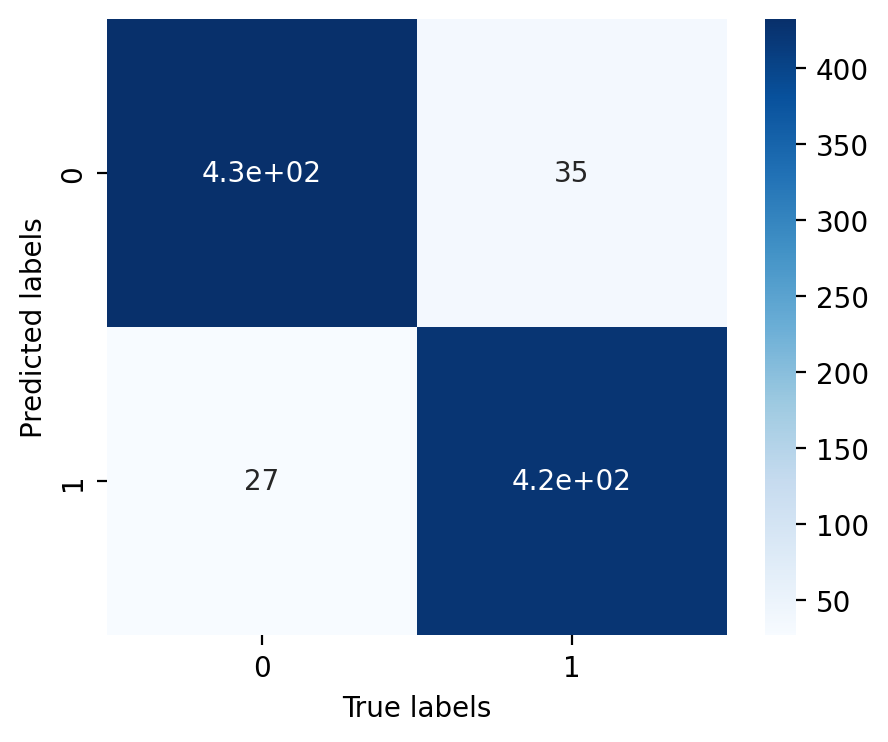

In [16]:
# Compute the confusion matrix
test_predictions = model.predict(X_test, verbose=0)
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(5, 4), dpi=200)
sns.heatmap(cm.T, annot=True, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [17]:
model.save(NAME_MODEL)

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp ConvNeXtCV_001.zip gdrive/MyDrive/

In [18]:
!zip -r {NAME_MODEL}.zip {NAME_MODEL} {NAME_PLOT}.png

  adding: ConvNeXtCV_001/ (stored 0%)
  adding: ConvNeXtCV_001/variables/ (stored 0%)
  adding: ConvNeXtCV_001/variables/variables.index (deflated 77%)
  adding: ConvNeXtCV_001/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: ConvNeXtCV_001/saved_model.pb (deflated 93%)
  adding: ConvNeXtCV_001/fingerprint.pb (stored 0%)
  adding: ConvNeXtCV_001/keras_metadata.pb (deflated 96%)
  adding: ConvNeXtCV_001/assets/ (stored 0%)
  adding: ConvNeXtCV_001_plot.png (deflated 15%)


In [ ]:
del ft_model

In [19]:
ft_model = tfk.models.load_model(NAME_MODEL)

In [20]:
ft_model.get_layer('convnext_base').trainable = True
c = 0
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
   c += 1

print(c)

295


In [21]:
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers[:200]):
  layer.trainable=False

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001), metrics=['accuracy'])

In [22]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',         # Metric to monitor (validation mean squared error in this case)
    patience=5,                     # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.80,                    # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                     # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                     # Minimum learning rate
)

callbacks = [early_stopping,lr_scheduler]

history = ft_model.fit(
    train_ds,
    epochs = EPOCHS,
    validation_data = val_ds,
    callbacks = callbacks
).history

Epoch 1/200
29/29 [==============================] - 89s 978ms/step - loss: 0.7622 - accuracy: 0.7375 - val_loss: 0.4041 - val_accuracy: 0.8271 - lr: 0.0010
Epoch 2/200
29/29 [==============================] - 12s 410ms/step - loss: 0.2981 - accuracy: 0.8824 - val_loss: 0.4495 - val_accuracy: 0.7913 - lr: 0.0010
Epoch 3/200
29/29 [==============================] - 10s 348ms/step - loss: 0.0900 - accuracy: 0.9706 - val_loss: 0.8500 - val_accuracy: 0.8297 - lr: 0.0010
Epoch 4/200
29/29 [==============================] - 12s 408ms/step - loss: 0.0580 - accuracy: 0.9804 - val_loss: 0.7640 - val_accuracy: 0.8592 - lr: 0.0010
Epoch 5/200
29/29 [==============================] - 11s 399ms/step - loss: 0.0602 - accuracy: 0.9793 - val_loss: 0.6423 - val_accuracy: 0.8592 - lr: 0.0010
Epoch 6/200
29/29 [==============================] - 10s 333ms/step - loss: 0.0437 - accuracy: 0.9837 - val_loss: 0.9694 - val_accuracy: 0.8451 - lr: 0.0010
Epoch 7/200
29/29 [==============================] - 10s 3

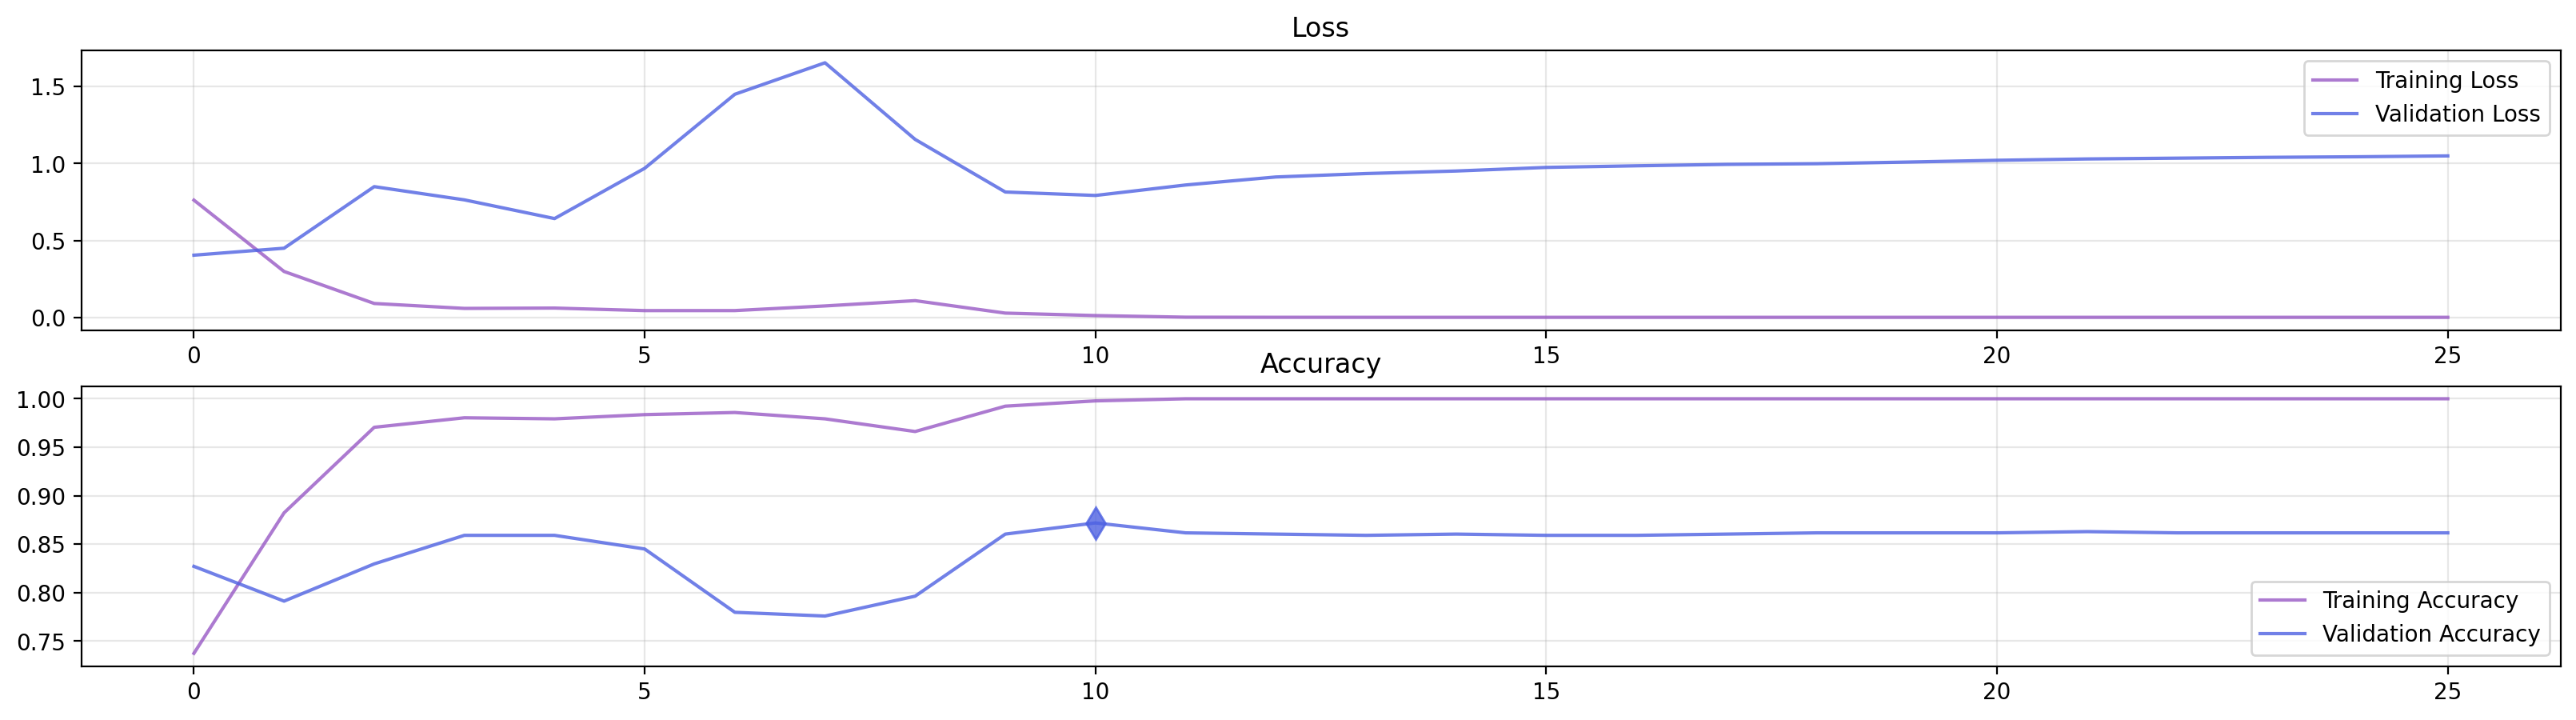

Accuracy Score over the Test Set: 1.0



In [23]:
plot_losses(history, (20,5), NAME_PLOT)

test_predictions = ft_model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
test_gt = np.argmax(y_test, axis=-1)
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
print()

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0


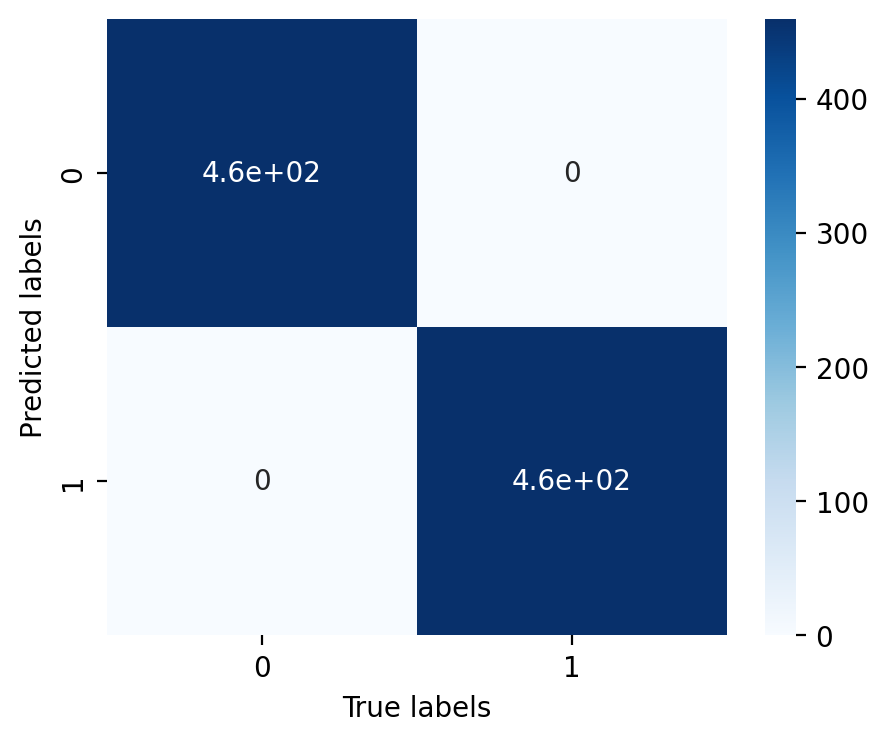

In [24]:
# Compute the confusion matrix
test_predictions = ft_model.predict(X_test, verbose=0)
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(5, 4), dpi=200)
sns.heatmap(cm.T, annot=True, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [28]:
ft_model.save(NAME_MODEL)

In [30]:
!zip -r {FT_NAME}.zip {NAME_MODEL} {FT_PLOT}.png

	zip warning: name not matched: ConvNeXtCV_001_plot_Tuning.png
  adding: ConvNeXtCV_001/ (stored 0%)
  adding: ConvNeXtCV_001/variables/ (stored 0%)
  adding: ConvNeXtCV_001/variables/variables.index (deflated 78%)
  adding: ConvNeXtCV_001/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: ConvNeXtCV_001/saved_model.pb (deflated 92%)
  adding: ConvNeXtCV_001/fingerprint.pb (stored 0%)
  adding: ConvNeXtCV_001/keras_metadata.pb (deflated 96%)
  adding: ConvNeXtCV_001/assets/ (stored 0%)


In [29]:
FT_NAME = NAME_MODEL+"_Tuning"
FT_PLOT = NAME_PLOT+"_Tuning"

In [31]:
!cp ConvNeXtCV_001_Tuning.zip drive/MyDrive